In [2]:

import matplotlib.pyplot as plt # https://matplotlib.org/
import numpy as np # http://www.numpy.org/
import tekwfm
import os
from scipy import integrate
from scipy.optimize import curve_fit
import pandas as pd
from scipy.stats import moyal as moyal_dist


In [3]:
doVerbose = False

#import the wfm file
filename_base = "170226_muoncal_20000_1900_1_on_ch2"


#saving the processed file
folder_name = "proc"
file_name = "170226_muoncal_20000_1900_1_on_ch2_proc.csv" 
file_path = os.path.join(os.getcwd(), folder_name, file_name)


startEvent = 0
nEvents = 20000

# code here to pass arguments

volts, tstart, tscale, tfrac, tdatefrac, tdate = tekwfm.read_wfm(filename_base+".wfm")
if doVerbose:
    print('>>>>', volts, tstart, tscale, tfrac, tdatefrac, tdate)

samples = volts.shape

print(len(volts))
print(tscale)
print('samples', samples[0])
tstop = samples[0]*tscale+tstart
sampleTimes = [tstart+x*tscale for x in range(samples[0])]


negVolts = [volts[:, event] for event in range(startEvent, startEvent + nEvents)] # all events, array of array of voltages
#tempVolts = -1 * negVolts # makes pulses positive
tempVolts = [-v for v in negVolts]


3125
8e-11
samples 3125


In [4]:
"""variables which can be changed"""
baseline_end_frac = 0.05
amplitude_start_frac = 0
amplitude_end_frac = 0.6
pulse_end_frac = 0.99

In [5]:
#find baseline and correction, baseline sd, amplitude, integral (entire window)

def calcbaseline(tempVolt, samples):
    baseline_voltages = tempVolt[0: int(baseline_end_frac*samples[0])]
    mean_baseline_voltages = tempVolt[0: int(baseline_end_frac*samples[0])]
    mean_b = np.mean(mean_baseline_voltages)
    sigma_b = np.std(baseline_voltages, ddof=1)
    correct_tempVolt = tempVolt - mean_b
    return mean_b, sigma_b, correct_tempVolt

def correcting_tempVolts(tempVolts, mean_b):
    corrected_tempVolts = []
    for i, tempVolt in enumerate(tempVolts):
        corrected = tempVolt - mean_b[i]
        corrected_tempVolts.append(corrected)
    return corrected_tempVolts

def calcamplitude(corrected_tempVolt, sampleTimes):
    peak_index = np.argmax(corrected_tempVolt)
    amplitude = corrected_tempVolt[peak_index]
    peak_time = sampleTimes[peak_index]
    return amplitude, peak_index, peak_time

def single_charge_integral(corrected_tempVolt, sampleTimes):
    single_integral = integrate.trapezoid(corrected_tempVolt, x=sampleTimes)
    return single_integral



In [6]:
#loop over all events
event_index_array=[]
mean_b_array = []
sigma_b_array = []
corrected_tempVolts = []
all_amplitudes = []
all_peak_times = []
all_peak_indices = []
all_integrals = []

for tempVolt in tempVolts:
    mean_b, sigma_b, corrected_tempVolt = calcbaseline(tempVolt, samples)
    mean_b_array.append(mean_b)
    sigma_b_array.append(sigma_b)
    corrected_tempVolts.append(corrected_tempVolt)

mean_b_array = np.array(mean_b_array)
sigma_b_array = np.array(sigma_b_array)
corrected_tempVolts = np.array(corrected_tempVolts)

for event_index, corrected_tempVolt in enumerate(corrected_tempVolts):
    true_event_number = startEvent + event_index
    amplitude, first_peak_index, first_peak_time = calcamplitude(corrected_tempVolt, sampleTimes)
    single_integral = single_charge_integral(corrected_tempVolt, sampleTimes)

    event_index_array.append(true_event_number)
    all_amplitudes.append(amplitude)
    all_peak_times.append(first_peak_time)
    all_peak_indices.append(first_peak_index)
    all_integrals.append(single_integral)

all_amplitudes = np.array(all_amplitudes)
all_peak_times = np.array(all_peak_times)
all_peak_indices = np.array(all_peak_indices)
all_integrals = np.array(all_integrals)


Fit completed max 3 iterations.


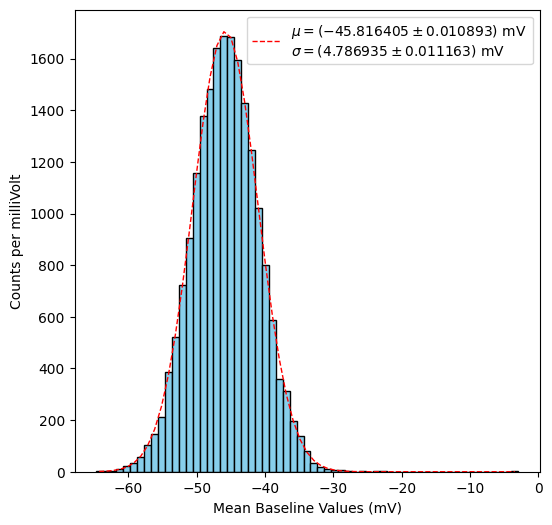

Converged after 1 iterations.


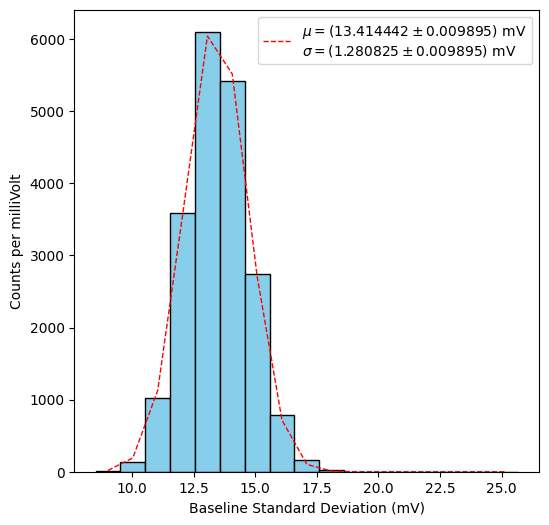

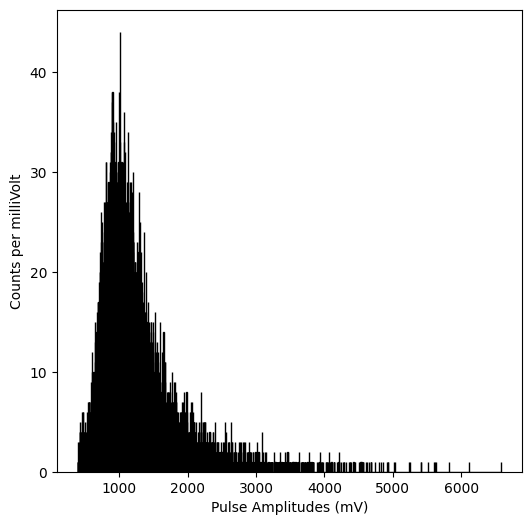

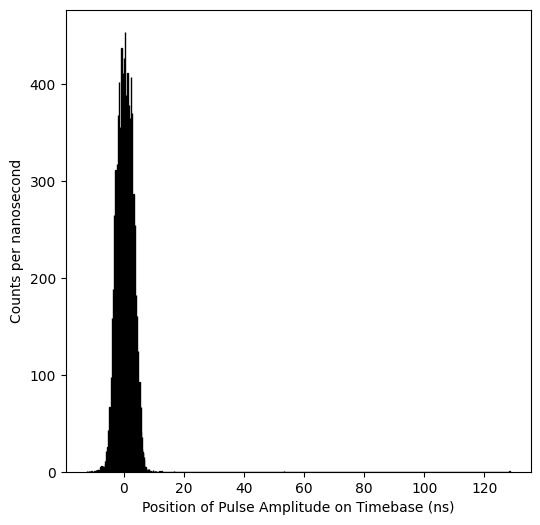

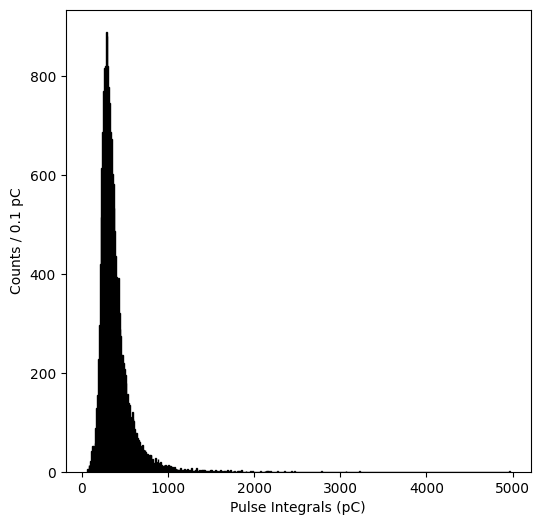

In [7]:
#produce plots
mean_b_array_mV = mean_b_array * 1000
sigma_b_array_mV = sigma_b_array * 1000

#histogram and gaussian for baseline mean
plt.figure(figsize=(6, 6))
def gaussian_mb(mean_b_array_mV, amp,  mu, sigma):
    gauss_mb = amp * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-0.5 * (mean_b_array_mV - mu)**2)/ sigma**2)
    return gauss_mb

bm_number_of_bins = int((np.max(mean_b_array_mV)-np.min(mean_b_array_mV))/1) #chosen 1 bin = 1 mV
n, bins, patches = plt.hist(mean_b_array_mV, bins=bm_number_of_bins, color = 'skyblue', edgecolor = 'black')
bin_centers = 0.5 * (bins[1:] + bins[:-1])

MAX_ITERATIONS = 3
SIGMA_THRESHOLD = 3.0  # Remove points > 3 standard deviations away

X_fit = bin_centers.copy()
Y_fit = n.copy()
p0 = [np.max(n), np.mean(bin_centers), np.std(bin_centers)]

final_popt = None
final_pcov = None
final_mask = None

for i in range(MAX_ITERATIONS):
    try:
        # 1. Fit the current data
        popt, pcov = curve_fit(gaussian_mb, X_fit, Y_fit, p0=p0)
        # store results
        final_popt = popt
        final_pcov = pcov
        # 2. Calculate the fitted curve and residuals
        Y_fitted = gaussian_mb(X_fit, *popt)
        residuals = Y_fit - Y_fitted
        # 3. Calculate the standard deviation of the residuals (a measure of fit scatter)
        residual_std = np.std(residuals)
        
        # 4. Create a mask to identify outliers
        mask = np.abs(residuals) < (SIGMA_THRESHOLD * residual_std)
        
        # If no points are removed, the process is stable; stop
        if np.all(mask):
            print(f"Converged after {i+1} iterations.")
            break
            
        # 5. Apply the mask to remove outliers for the next iteration
        X_fit = X_fit[mask]
        Y_fit = Y_fit[mask]
        
        # Update the initial guess (p0) for the next iteration with the current fit
        p0 = popt
        
    except RuntimeError:
        print(f"Fit failed during iteration {i+1}. Stopping.")
        break
else:
    print(f"Fit completed max {MAX_ITERATIONS} iterations.")
# calculate final errors and plot
if final_popt is None:
    print("Error: No successful fit achieved.")
else:
    mb_fit_full = gaussian_mb(bin_centers, *final_popt)
    err_mu = np.sqrt(final_pcov[1,1])
    err_sigma = np.sqrt(final_pcov[2,2])
    plt.plot(bin_centers, mb_fit_full, 'r--', linewidth=1)
    #plt.xlim(-1, 4)
    plt.xlabel('Mean Baseline Values (mV)')
    plt.ylabel('Counts per milliVolt')
    plt.legend([
    r'$\mu=(%.6f \pm %.6f)\ \mathrm{mV}$'  # First line: Mean ($\mu$)
    '\n'                                              # Newline character
    r'$\sigma=(%.6f \pm %.6f)\ \mathrm{mV}$' % (        # Second line: Std Dev ($\sigma$)
        popt[1], err_mu, popt[2], err_sigma)], loc='best', fontsize=10)
    plt.show()



# histogram and gaussian for baseline standard deviations
plt.figure(figsize=(6, 6))

def gaussian_sb(sigma_b_array_mV, amp,  mu, sigma):
    gauss_sb = amp * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-0.5 * (sigma_b_array_mV - mu)**2)/ sigma**2)
    return gauss_sb

sb_number_of_bins = int((np.max(sigma_b_array_mV)-np.min(sigma_b_array_mV))/1) #chosen 1 bin = 1mV
n, bins, patches = plt.hist(sigma_b_array_mV, bins=sb_number_of_bins, color='skyblue', edgecolor='black')
bin_centers = 0.5 * (bins[1:] + bins[:-1])
MAX_ITERATIONS = 3
SIGMA_THRESHOLD = 3.0  # Remove points > 3 standard deviations away

fit_mask = (bin_centers >=-100) & (bin_centers <=100)
bin_centers_filtered = bin_centers[fit_mask]
n_filtered = n[fit_mask]

X_fit = bin_centers_filtered.copy()
Y_fit = n_filtered.copy()
p0 = [np.max(n_filtered), np.mean(bin_centers_filtered), np.std(bin_centers_filtered)]

final_popt = None
final_pcov = None
final_mask = None

for i in range(MAX_ITERATIONS):
    try:
# 1. Fit the current data
        popt, pcov = curve_fit(gaussian_sb, X_fit, Y_fit, p0=p0)
        # store results
        final_popt = popt
        final_pcov = pcov
        # 2. Calculate the fitted curve and residuals
        Y_fitted = gaussian_sb(X_fit, *popt)
        residuals = Y_fit - Y_fitted
        # 3. Calculate the standard deviation of the residuals (a measure of fit scatter)
        residual_std = np.std(residuals)
        
        # 4. Create a mask to identify outliers
        mask = np.abs(residuals) < (SIGMA_THRESHOLD * residual_std)
        
        # If no points are removed, the process is stable; stop
        if np.all(mask):
            print(f"Converged after {i+1} iterations.")
            break
            
        # 5. Apply the mask to remove outliers for the next iteration
        X_fit = X_fit[mask]
        Y_fit = Y_fit[mask]
        
        # Update the initial guess (p0) for the next iteration with the current fit
        p0 = popt
        
    except RuntimeError:
        print(f"Fit failed during iteration {i+1}. Stopping.")
        break
else:
    print(f"Fit completed max {MAX_ITERATIONS} iterations.")
# calculate final errors and plot
if final_popt is None:
    print("Error: No successful fit achieved.")
else:
    sb_fit_full = gaussian_sb(bin_centers, *final_popt)
    err_mu = np.sqrt(final_pcov[1,1])
    err_sigma = np.sqrt(final_pcov[2,2])
    plt.plot(bin_centers, sb_fit_full, 'r--', linewidth=1)
    #plt.xlim(0, 5)
    plt.xlabel('Baseline Standard Deviation (mV)')
    plt.ylabel('Counts per milliVolt')
    plt.legend([
    r'$\mu=(%.6f \pm %.6f)\ \mathrm{mV}$'  # First line: Mean ($\mu$)
    '\n'                                              # Newline character
    r'$\sigma=(%.6f \pm %.6f)\ \mathrm{mV}$' % (        # Second line: Std Dev ($\sigma$)
        popt[1], err_mu, popt[2], err_sigma)], loc='best', fontsize=10)
    plt.show()



# histogram for Peak Amplitudes
plt.figure(figsize=(6, 6))
all_amplitudes_mV = all_amplitudes * 1000
amp_number_of_bins = int((np.max(all_amplitudes_mV)-np.min(all_amplitudes_mV))/1) #chosen 1 bin = 1mV
plt.hist(all_amplitudes_mV, bins=amp_number_of_bins, color='skyblue', edgecolor='black')
#plt.xlim(0,250)
#plt.ylim(0,80)
plt.xlabel('Pulse Amplitudes (mV)')
plt.ylabel('Counts per milliVolt')
plt.show()




# histogram of Peak Times
plt.figure(figsize=(6, 6))
all_peak_times_ns = all_peak_times *1e9
pt_number_of_bins = int((np.max(all_peak_times_ns)-np.min(all_peak_times_ns))/0.1) #chosen 1 bin = 0.1ns
plt.hist(all_peak_times_ns, bins=pt_number_of_bins, color='skyblue', edgecolor='black')
#plt.xlim(-1,13)
#plt.ylim(0,2000)
plt.xlabel('Position of Pulse Amplitude on Timebase (ns)')
plt.ylabel('Counts per nanosecond')
plt.show()



# histogram of pulse integrals in units of charge
Resistance = ((1/10000) + (1/50))**(-1)
all_integrals_picocharge = (all_integrals * 1e12) / Resistance
plt.figure(figsize=(6, 6))
int_number_of_bins = int((np.max(all_integrals_picocharge)-np.min(all_integrals_picocharge))/10) #chosen 1 bin = 10 pC
plt.hist(all_integrals_picocharge, bins=int_number_of_bins, color='skyblue', edgecolor='black')
#plt.xlim(-5, 100)
#plt.ylim(0,1500)
plt.xlabel('Pulse Integrals (pC)')
plt.ylabel('Counts / 0.1 pC')
plt.show()

In [8]:
#export to csv
df = pd.DataFrame({
            'event_id': event_index_array, 
            'baseline': mean_b_array,
            'sd_baseline': sigma_b_array,
            'amplitude': all_amplitudes,
            'peak_time': all_peak_times,
            'integral_pC': all_integrals_picocharge        
            })


#df.to_csv(file_path, sep=',', encoding='utf-8-sig', index=False, header=True)

print('CSV done!')

CSV done!


In [9]:
t0 = tdate[0] + tdatefrac[0]
tlast = tdate[-2] + tdatefrac[-2]
timetaken = tlast - t0

rate = (len(tdate)-1) / timetaken

print(rate)

15.46404625330278


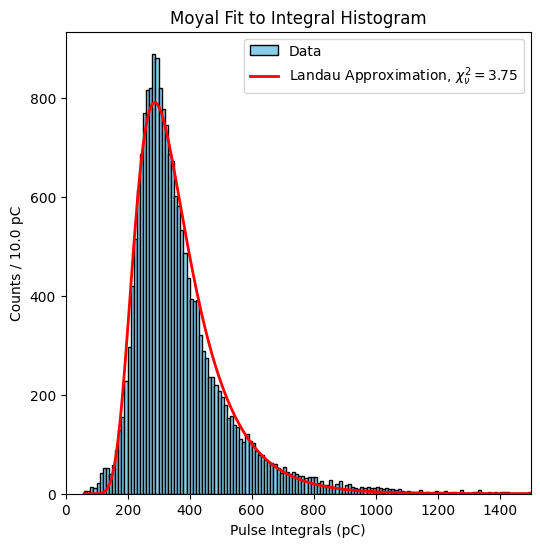

Fitted Most Probable Integral Value (mu) = 287.3957 pC
Fitted sigma = 61.2841 pC


In [10]:
#fitting moyal (landau approximation) to integral histogram
#NORMALISED
bin_width = 10  # 1 pC per bin

n_bins = int(
    (np.max(all_integrals_picocharge) -
     np.min(all_integrals_picocharge)) / bin_width
)

counts, bins = np.histogram(all_integrals_picocharge,
                            bins=n_bins)

bin_centers = 0.5 * (bins[1:] + bins[:-1])
bin_width = bins[1] - bins[0]   # ensure exact width

#define moyal distribution, scale by N x bin width
def moyal_norm(x, mu, sigma):
    return len(all_integrals_picocharge) * bin_width * \
           moyal_dist.pdf(x, loc=mu, scale=sigma)

#initial guesses for mu and sigma
p0 = [300, 60]


sigma=np.sqrt(counts)
sigma[sigma==0.0] = 1

#fit
params, cov = curve_fit(
    moyal_norm,
    bin_centers,
    counts,
    p0=p0,
    sigma=sigma,
    absolute_sigma=True,
    maxfev=10000
)

mu_fit, sigma_fit = params

model_fit = moyal_norm(bin_centers, *params)
valid = counts > 0
chi2 = np.sum((counts[valid] - model_fit[valid])**2 / counts[valid])
ndof = np.sum(valid) - len(params)
chi2_red = chi2 / ndof


#plot
x_fit = np.linspace(min(all_integrals_picocharge),
                    max(all_integrals_picocharge),
                    1000)

plt.figure(figsize=(6, 6))

plt.hist(all_integrals_picocharge,
         bins=n_bins,
         color='skyblue',
         edgecolor='black', label='Data')

plt.plot(x_fit,
         moyal_norm(x_fit, mu_fit, sigma_fit),
         'r-',
         linewidth=2, label=rf'Landau Approximation, $\chi^2_\nu={chi2_red:.2f}$')

plt.xlabel('Pulse Integrals (pC)')
plt.ylabel(f'Counts / {bin_width:.1f} pC')
plt.title('Moyal Fit to Integral Histogram')
plt.xlim(0,1500)
plt.legend()
plt.show()

print(f"Fitted Most Probable Integral Value (mu) = {mu_fit:.4f} pC")
print(f"Fitted sigma = {sigma_fit:.4f} pC")


Moyal Distribution:
$\frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma} + e^{-\frac{x-\mu}{\sigma}})}$

/Users/ameliamattison/Documents/Uni/Year 4/Project/DMProject/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


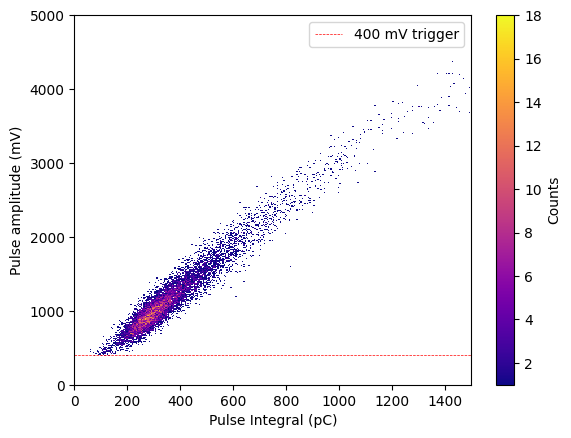

In [11]:
#charge-amplitude

#amplitude in mV
amplitudes = all_amplitudes * 1000

pulse_integrals = all_integrals_picocharge

h = plt.hist2d(
    pulse_integrals, 
    amplitudes, 
    bins=1000,           # finer resolution
    density=False, 
    cmap='plasma',     # nicer color map
    cmin=1
)

plt.ylabel('Pulse amplitude (mV)')
plt.xlabel('Pulse Integral (pC)')
plt.colorbar(h[3], label='Counts')  # colorbar
plt.xlim([0, 1500])
plt.ylim([0, 5000])
plt.axhline(y=400, color='red', linestyle='--', linewidth=0.5, label='400 mV trigger')
plt.legend()
plt.show()